In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [3]:
np.random.seed(525)
mean_dict = {"1":[4, 4],"2":[-4, 4],"3":[4, -4],"4":[-4, -4],"5":[-6, 6]}
var_dict =  {"1":[[1, 0], [0, 1]],"2":[[3, 0], [0, 1]],"3":[[1, 0], [0, 1]],"4":[[1, 0], [0, 1]], "5":[[1, 0], [0, 3]]}
data = np.empty((1,2))
sample_size = 200
for key in mean_dict.keys():
    data = np.append(data,np.random.multivariate_normal(mean_dict[key], var_dict[key], sample_size),axis=0)
data = data[1:]

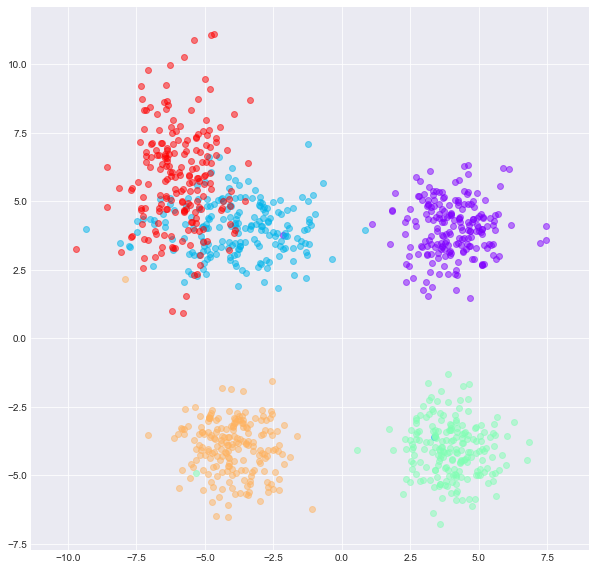

In [4]:
colors = cm.rainbow(np.linspace(0, 1, 5))
x1, y1 = data[0:sample_size+1].T
x2, y2 = data[sample_size+1:2*sample_size+1].T
x3, y3 = data[2*sample_size+1:3*sample_size+1].T
x4, y4 = data[3*sample_size+1:4*sample_size+1].T
x5, y5 = data[4*sample_size+1:5*sample_size+1].T
fig = plt.figure(figsize=(10, 10))
plt.ion()
plt.style.use('seaborn-darkgrid')
plt.scatter(x1, y1, c=colors[0],alpha=0.5)
plt.scatter(x2, y2, c=colors[1],alpha=0.5)
plt.scatter(x3, y3, c=colors[2],alpha=0.5)
plt.scatter(x4, y4, c=colors[3],alpha=0.5)
plt.scatter(x5, y5, c=colors[4],alpha=0.5)
plt.axis('equal')
plt.savefig("./outputs/report_figs/simulation_original.jpeg", dpi=400)
plt.show()

In [4]:
import pandas as pd
from sklearn.datasets import make_spd_matrix
from scipy.special import gammaln, psi
import numpy as np
from numpy.linalg import det, inv, eigh
from utils import update_r_prime, r_prime_init, plot_iteration

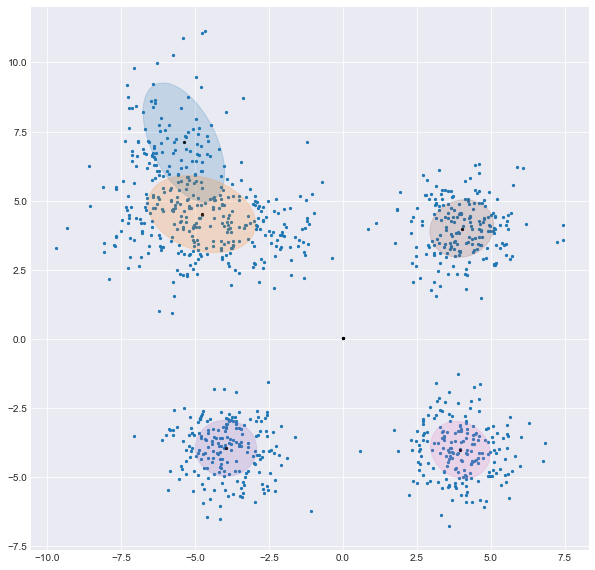

In [5]:
import pandas as pd
from sklearn.datasets import make_spd_matrix
from scipy.special import gammaln, psi
import numpy as np
from numpy.linalg import det, inv, eigh
from utils import update_r_prime, r_prime_init, plot_iteration
xn = data
# D for dimension, N for data size
N, D = data.shape
data = np.array(data)
# number of cluster
K = 7

# priors for pi
alpha_0 = np.ones((K,))  # concentration para for \pi
# prior for cov matrix(wishart distribution)
nu_0 = np.array([D])  # prior degree of freedom
w_0_inv = inv(make_spd_matrix(D))  # prior scale matrix
# prior for mu(normal distribution)
m_0 = np.zeros((D,))  # mean for mu, dimension D
beta_0 = np.array([0.9])  # adjustment for variance for cov matrix, dimension 1

# variational parameter
# assignment parameter
r_prime = r_prime_init(N, method="dirichlet", alpha_0=alpha_0)
#r_prime = np.random.dirichlet(N, method="dirichlet", alpha_0=alpha_0)
alpha_prime = np.zeros(shape=K)
# parameter for mu and cov matrix
nu_prime = np.zeros(shape=K)
w_inv_prime = np.zeros(shape=(K, D, D))
beta_prime = np.zeros(shape=K)
m_prime = lambda_m = np.zeros(shape=(K, D))

plt.ion()
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 10))
ax_spatial = fig.add_subplot(1, 1, 1)
circs = []
sctZ = None

# parameter update
for step in range(80):
    Nk = np.sum(r_prime, axis=0)
    alpha_prime = alpha_0 + Nk
    beta_prime = beta_0 + Nk
    nu_prime = nu_0 + Nk
    # calculate xk
    xk = np.zeros((K, D))
    for k in range(K):
        for j in range(D):
            d = np.array(data[:, j].flatten())
            xk[k][j] = d.dot(r_prime[:, k])/Nk[k]
    # update m prime
    for k in range(K):
        m_prime[k, :] = (beta_0*m_0 + Nk[k]*xk[k, :])/beta_prime[k]
    # update w_inv prime
    for k in range(K):
        Sk = np.zeros((2, 2))
        para = beta_0*Nk[k]/(beta_0+Nk[k])
        for n in range(N):
            Sk += r_prime[n, k]*(data[n, :]-xk[k, :]).reshape(1, -1).T*(data[n, :]-xk[k, :]).reshape(1, -1)/Nk[k]
        w_inv_prime[k] = w_0_inv + Nk[k]*Sk + para*(xk[k, :]-m_0).reshape(1, -1).T*(xk[k, :]-m_0).reshape(1, -1)
    r_prime = update_r_prime(data, alpha_prime, w_inv_prime, nu_prime, beta_prime, m_prime, N, D, K)

    lambda_w = w_inv_prime
    lambda_nu = nu_prime
    lambda_m = m_prime
    covs = [lambda_w[k, :, :] / (lambda_nu[k] - D - 1)
            for k in range(K)]

    ax_spatial, circs, sctZ = plot_iteration(ax_spatial, circs,
                                             sctZ, lambda_m,
                                             covs, xn,
                                             step, K)
#     if step % 10 == 0:
#         plt.savefig(figs + "iter_{}.png".format(step), dpi=200)
# plt.savefig(figs + "final.png", dpi=400)

In [6]:
lambda_m

array([[-5.38733023e+00,  7.10336456e+00],
       [-4.78208534e+00,  4.51086388e+00],
       [ 3.65743269e-03,  1.87516540e-02],
       [ 3.65743269e-03,  1.87516540e-02],
       [-3.96350417e+00, -3.96768273e+00],
       [ 4.01886943e+00,  3.98758647e+00],
       [ 3.96920980e+00, -4.02817217e+00]])

In [17]:
for i in covs:
    print(i)

[[ 1.01752036 -0.14162359]
 [-0.14162359  1.04600358]]
[[1.16450777 0.10561181]
 [0.10561181 1.06304257]]
[[ 1.66971627 -1.23071458]
 [-1.23071458  3.98818633]]
[[-0.38923223 -0.17801984]
 [-0.17801984 -1.00950365]]
[[ 3.38479277 -0.59060405]
 [-0.59060405  1.76509624]]
[[ 1.08207375 -0.01741037]
 [-0.01741037  1.00852065]]
[[-0.38923223 -0.17801984]
 [-0.17801984 -1.00950365]]


In [27]:
from sklearn import mixture
result = mixture.BayesianGaussianMixture(n_components=5, weight_concentration_prior_type="dirichlet_distribution",
                                        covariance_type='full', n_init =5, tol = 1e-4).fit(data)

In [28]:
cluster = result.predict(data)

In [29]:
result.covariances_

array([[[ 1.13071174, -0.04362158],
        [-0.04362158,  1.14687757]],

       [[ 1.28803988,  0.07754084],
        [ 0.07754084,  1.11090141]],

       [[ 1.15746939, -0.22771414],
        [-0.22771414,  1.18466903]],

       [[ 3.70639784, -0.15229225],
        [-0.15229225,  1.08036618]],

       [[ 1.34764104, -0.34395546],
        [-0.34395546,  3.68915961]]])

In [30]:
result.means_

array([[-3.96725274, -3.95988893],
       [ 4.01841727,  3.99122099],
       [ 3.9614793 , -4.0203784 ],
       [-4.16771979,  4.0241912 ],
       [-5.70402075,  5.95540298]])

# histgram

In [1]:
import cv2
import PIL 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
img_path = './data/iaprtc12/processed/02/2018.jpg'
img_data = cv2.imread(img_path)
color = ('b','g','r')
im = np.array([])
for i,col in enumerate(color):
    histr = cv2.calcHist([img_data],[i],None,[255],[0,255])
    histr = histr.flatten()
    im = np.concatenate((im, histr))

In [2]:
blue=im[0:255]
green = im[255:255*2]
red = im[255*2:255*3]

In [3]:
# Image.open(img_path)
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
# ax1.plot(range(len(blue)),blue, "b",label="b")
# ax2.plot(range(len(green)),green, "g",label="g")
# ax3.plot(range(len(red)),red, "r",label="r")
# ax3.set_xlabel('pixel intensity')
# plt.show()

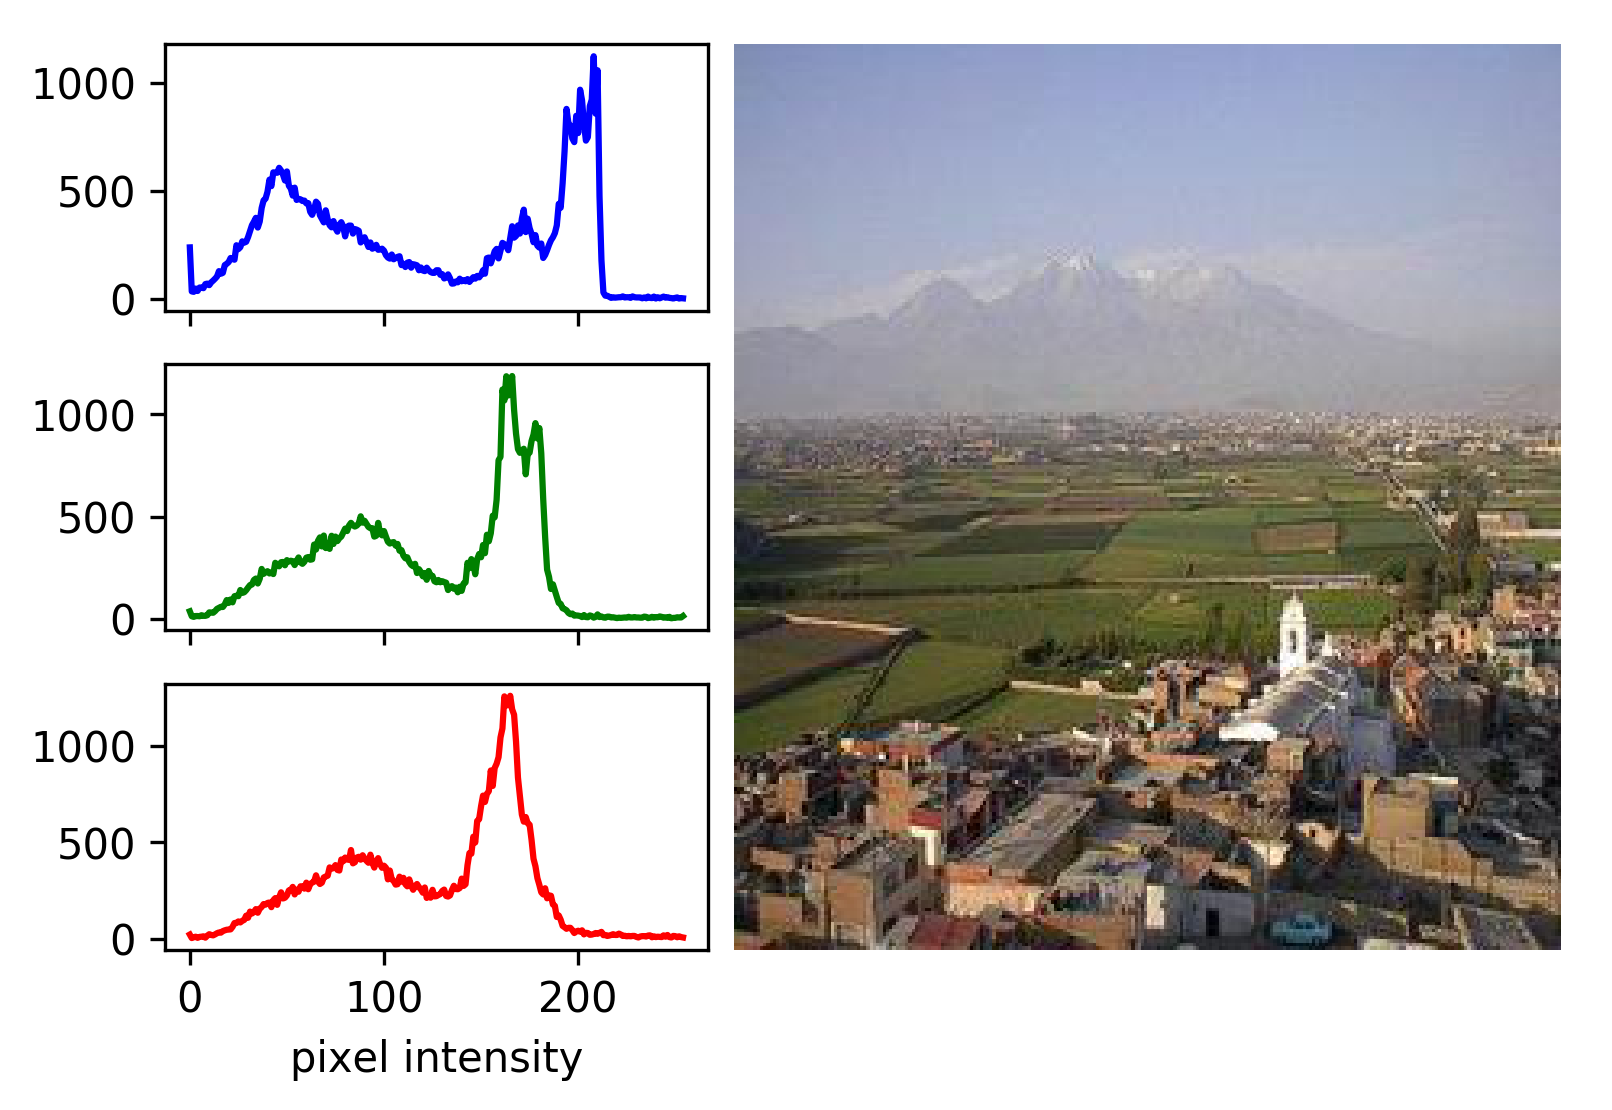

In [5]:
import matplotlib.gridspec as gridspec
fig = plt.figure(dpi=300)
gs = gridspec.GridSpec(3, 5, height_ratios=[1,1,1])
gs.update( wspace=0.1)
ax1 = plt.subplot(gs[0, 0:2])
ax1.set_xticklabels([])
ax2 = plt.subplot(gs[1, 0:2])
ax2.set_xticklabels([])
ax3 = plt.subplot(gs[2, 0:2])
ax1.plot(range(len(blue)),blue, "b",label="b")
ax2.plot(range(len(green)),green, "g",label="g")
ax3.plot(range(len(red)),red, "r",label="r")
ax3.set_xlabel('pixel intensity')
ax = plt.subplot(gs[0:3, 2:6])
ax.imshow(np.asarray(Image.open(img_path)), aspect='auto')
ax.axis('off')
plt.savefig("./outputs/report_figs/hist_demo.jpeg")
plt.show()

## elbow

In [46]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_spd_matrix
from scipy.special import gammaln, psi
import numpy as np
from numpy.linalg import det, inv, eigh
from utils import update_r_prime, r_prime_init, plot_iteration, elbo
import os
from os.path import isfile, join

import numpy as np
from math import *
import math

from numpy.linalg import slogdet
import scipy.special
from scipy.special import gammaln

def multivariate_t_distribution(x, mu, Sigma, df, D):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n x d numpy array)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (d x d numpy array)
        df = degrees of freedom
    '''
    p = D
    dec = np.linalg.cholesky(Sigma)
    R_x_m = np.linalg.solve(dec,np.matrix.transpose(x)-mu)
    rss = np.power(R_x_m,2).sum(axis=0)
    logretval = lgamma(1.0*(p + df)/2) - (lgamma(1.0*df/2) + np.sum(np.log(dec.diagonal())) \
       + p/2 * np.log(math.pi * df)) - 0.5 * (df + p) * math.log1p((rss/df) )
    return np.exp(logretval)
def predictive_density(x, m, W, alpha, beta, nu, D, K):
    p = 0
    for k in range(K):
        Lk = (nu[k] + 1 - D) * beta[k] / (1 + beta[k]) * W[k,:,:]
        p += alpha[k] * multivariate_t_distribution(x, m[k],Lk, nu[k]+1-D, D)
    return p / np.sum(alpha)

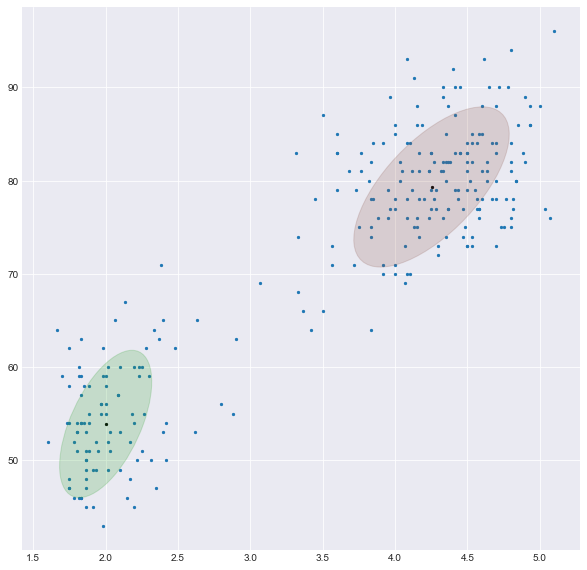

In [47]:
data = pd.read_csv('./data/oldfaithful.csv')
xn = []
for i in range(data.shape[0]):
    xn.append(list(data.iloc[i]))
xn = np.array(xn)
# D for dimension, N for data size
N, D = data.shape
data = np.array(data)
# number of cluster
K = 6

# priors for pi
alpha_0 = np.ones((K,))  # concentration para for \pi
# prior for cov matrix(wishart distribution)
nu_0 = np.array([D])  # prior degree of freedom
w_0_inv = inv(make_spd_matrix(D))  # prior scale matrix
# prior for mu(normal distribution)
m_0 = np.zeros((D,))  # mean for mu, dimension D
beta_0 = np.array([0.9])  # adjustment for variance for cov matrix, dimension 1

# variational parameter
# assignment parameter
r_prime = r_prime_init(N, method="dirichlet", alpha_0=alpha_0)
#r_prime = np.random.dirichlet(N, method="dirichlet", alpha_0=alpha_0)
alpha_prime = np.zeros(shape=K)
# parameter for mu and cov matrix
nu_prime = np.zeros(shape=K)
w_inv_prime = np.zeros(shape=(K, D, D))
beta_prime = np.zeros(shape=K)
m_prime = lambda_m = np.zeros(shape=(K, D))

plt.ion()
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 10))
ax_spatial = fig.add_subplot(1, 1, 1)
circs = []
sctZ = None
lbs = []
log_predivtive = []
# parameter update
for step in range(80):
    Nk = np.sum(r_prime, axis=0)
    alpha_prime = alpha_0 + Nk
    beta_prime = beta_0 + Nk
    nu_prime = nu_0 + Nk
    # calculate xk
    xk = np.zeros((K, D))
    for k in range(K):
        for j in range(D):
            d = np.array(data[:, j].flatten())
            xk[k][j] = d.dot(r_prime[:, k])/Nk[k]
    # update m prime
    for k in range(K):
        m_prime[k, :] = (beta_0*m_0 + Nk[k]*xk[k, :])/beta_prime[k]
    # update w_inv prime
    for k in range(K):
        Sk = np.zeros((D, D))
        para = beta_0*Nk[k]/(beta_0+Nk[k])
        for n in range(N):
            Sk += r_prime[n, k]*(data[n, :]-xk[k, :]).reshape(1, -1).T*(data[n, :]-xk[k, :]).reshape(1, -1)/Nk[k]
        w_inv_prime[k] = w_0_inv + Nk[k]*Sk + para*(xk[k, :]-m_0).reshape(1, -1).T*(xk[k, :]-m_0).reshape(1, -1)
    r_prime = update_r_prime(data, alpha_prime, w_inv_prime, nu_prime, beta_prime, m_prime, N, D, K)
    
        
    variance = w_inv_prime
    lambda_nu = nu_prime
    lambda_m = m_prime
    lambda_beta = beta_prime
    lb = elbo(xn, alpha_0, alpha_prime, r_prime, m_0,
                       lambda_m, beta_0, lambda_beta, nu_0,
                       lambda_nu, inv(w_0_inv), inv(variance), N, D, K)
    lbs.append(lb)


    covs = [variance[k, :, :] / (lambda_nu[k] - D - 1)
            for k in range(K)]

    ax_spatial, circs, sctZ = plot_iteration(ax_spatial, circs,
                                             sctZ, lambda_m,
                                             covs, xn,
                                             step, K)
    summation = 0
    for x in xn:
        summation += np.log(predictive(x, lambda_m, inv(variance), alpha_prime, beta_prime, lambda_nu, D, K))
    log_predivtive.append(summation / xn.shape[0])

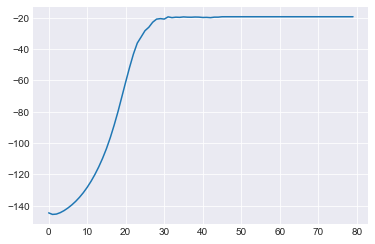

In [48]:
# plt.plot(range(len(lbs)), lbs)
# plt.xlabel("iteration")
# plt.ylabel("ELBO")
plt.plot(range(len(log_predivtive)), log_predivtive)

In [42]:
1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu))

722.9299822542567

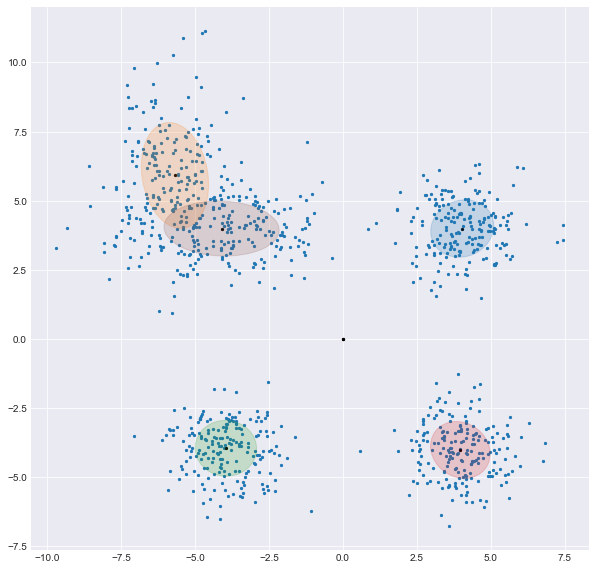

In [1]:
import pandas as pd
from sklearn.datasets import make_spd_matrix
from scipy.special import gammaln, psi
import numpy as np
from numpy.linalg import det, inv, eigh
from utils import update_r_prime, r_prime_init, plot_iteration, elbo, predictive_density
import pandas as pd
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from matplotlib.patches import Ellipse
from os.path import isfile, join
import imageio

np.random.seed(525)
mean_dict = {"1":[4, 4],"2":[-4, 4],"3":[4, -4],"4":[-4, -4],"5":[-6, 6]}
var_dict =  {"1":[[1, 0], [0, 1]],"2":[[3, 0], [0, 1]],"3":[[1, 0], [0, 1]],"4":[[1, 0], [0, 1]], "5":[[1, 0], [0, 3]]}
data = np.empty((1,2))
sample_size = 200
for key in mean_dict.keys():
    data = np.append(data,np.random.multivariate_normal(mean_dict[key], var_dict[key], sample_size),axis=0)
data_train = data[1:]

data = np.empty((1,2))
np.random.seed(425)
for key in mean_dict.keys():
    data = np.append(data,np.random.multivariate_normal(mean_dict[key], var_dict[key], sample_size),axis=0)
data_test = data[1:]

xn = data_train
# D for dimension, N for data size
N, D = data_train.shape
data_train = np.array(data_train)
# number of cluster
K = 7

# priors for pi
alpha_0 = np.ones((K,))  # concentration para for \pi
# prior for cov matrix(wishart distribution)
nu_0 = np.array([D])  # prior degree of freedom
w_0_inv = inv(make_spd_matrix(D))  # prior scale matrix
# prior for mu(normal distribution)
m_0 = np.zeros((D,))  # mean for mu, dimension D
beta_0 = np.array([0.9])  # adjustment for variance for cov matrix, dimension 1

# variational parameter
# assignment parameter
r_prime = r_prime_init(N, method="dirichlet", alpha_0=alpha_0)
#r_prime = np.random.dirichlet(N, method="dirichlet", alpha_0=alpha_0)
alpha_prime = np.zeros(shape=K)
# parameter for mu and cov matrix
nu_prime = np.zeros(shape=K)
w_inv_prime = np.zeros(shape=(K, D, D))
beta_prime = np.zeros(shape=K)
m_prime = lambda_m = np.zeros(shape=(K, D))

plt.ion()
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 10))
ax_spatial = fig.add_subplot(1, 1, 1)
circs = []
sctZ = None
lbs = []
log_predivtive = []
# parameter update
for step in range(80):
    Nk = np.sum(r_prime, axis=0)
    alpha_prime = alpha_0 + Nk
    beta_prime = beta_0 + Nk
    nu_prime = nu_0 + Nk
    # calculate xk
    xk = np.zeros((K, D))
    for k in range(K):
        for j in range(D):
            d = np.array(data_train[:, j].flatten())
            xk[k][j] = d.dot(r_prime[:, k])/Nk[k]
    # update m prime
    for k in range(K):
        m_prime[k, :] = (beta_0*m_0 + Nk[k]*xk[k, :])/beta_prime[k]
    # update w_inv prime
    for k in range(K):
        Sk = np.zeros((2, 2))
        para = beta_0*Nk[k]/(beta_0+Nk[k])
        for n in range(N):
            Sk += r_prime[n, k]*(data_train[n, :]-xk[k, :]).reshape(1, -1).T*(data_train[n, :]-xk[k, :]).reshape(1, -1)/Nk[k]
        w_inv_prime[k] = w_0_inv + Nk[k]*Sk + para*(xk[k, :]-m_0).reshape(1, -1).T*(xk[k, :]-m_0).reshape(1, -1)
    r_prime = update_r_prime(data_train, alpha_prime, w_inv_prime, nu_prime, beta_prime, m_prime, N, D, K)

    variance = w_inv_prime
    lambda_nu = nu_prime
    lambda_m = m_prime
    lambda_beta = beta_prime
    
    lb = elbo(xn, alpha_0, alpha_prime, r_prime, m_0,
              lambda_m, beta_0, lambda_beta, nu_0,
              lambda_nu, inv(w_0_inv), inv(variance), N, D, K)
    lbs.append(lb)
    
    covs = [variance[k, :, :] / (lambda_nu[k] - D - 1)
            for k in range(K)]
    summation = 0
    for x in data_test:
        summation += np.log(predictive_density(x, lambda_m, inv(variance), alpha_prime, beta_prime, lambda_nu, D, K))
    log_predivtive.append(summation / xn.shape[0])
    
    ax_spatial, circs, sctZ = plot_iteration(ax_spatial, circs,
                                             sctZ, lambda_m,
                                             covs, xn,
                                             step, K)
    if step % 10 == 0:
        plt.savefig(figs + "iter_{}.png".format(step), dpi=200)
plt.savefig(figs + "final.png", dpi=400)

img_folder = figs
imgs = [f for f in os.listdir(img_folder) if isfile(join(img_folder, f))]
imgs.pop(0)
images = []
for img in imgs:
    images.append(imageio.imread(figs + "{}".format(img)))
kargs = {'duration': 0.5}
imageio.mimsave(figs+'process.gif', images, **kargs)

model = {"mean": lambda_m, "var": covs}

np.save(model_url + "simulation.npy", model)

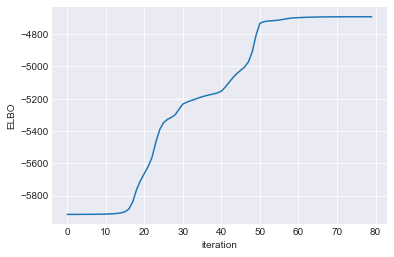

In [2]:
plt.clf()
plt.plot(range(len(lbs)), lbs)
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.show()

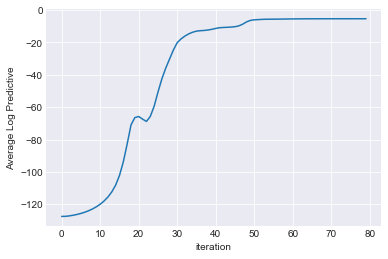

In [3]:
plt.clf()
plt.plot(range(len(log_predivtive)), log_predivtive)
plt.xlabel("iteration")
plt.ylabel("Average Log Predictive")
plt.show()

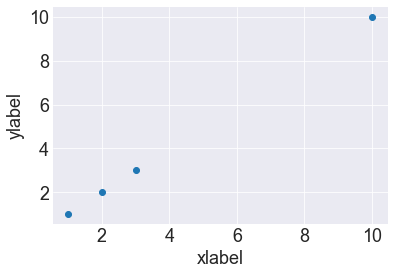

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.array([1,2,3,10])
ax.scatter(x, x)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

In [31]:
r = np.load()

In [44]:
import pickle
with open("./outputs/model/simulation.pickle", "rb") as input_file:
    e = pickle.load(input_file)

In [46]:
elbo = e["elbo"]

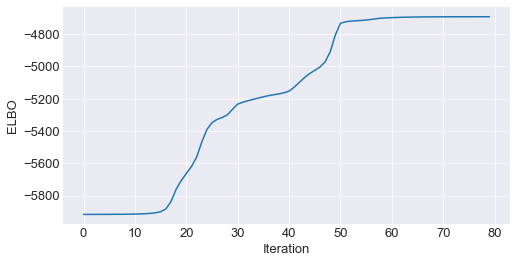

In [64]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.plot(range(len(lbs)), lbs)
plt.xlabel("Iteration", fontsize=13)
plt.ylabel("ELBO", fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.savefig("./outputs/simulation/elbo.png", dpi=400)